# Loan Default Prediction - Classfication

## Part 3. Model Selection + Model Evaluation

**This notebook contains code for:**
1. **Model selection,**
2. **Model evaluation.**

---
<a id='toc'></a>
**Table of Contents**
1. [**Train/Test Split**](#split): Chronologically
2. [**Model Selection**](#select)
    Metrics: F1_Score, ROC_AUC_Score, Average_Precision
    1. Models to Try:
        - Linear Models: 
            - Logistic Regression
            - SVM: SGDClassifier
        - Naive Bayes
        - Tree Based Models:
            - Random Forest Classficaiton
    2. [Model Training](#train)
        1. [Build Pipeline](#train)
        2. [GridSearch](#grid)
    3. [XGBoost Classification](#xgb)
    4. [Feature importance and model performance](#plot)
3. [**Analysis/Evaluation Data Split**](#azeval): further split test data into analyze portion for threshold selection and evaluation portion for performance evaluation of chosen model/hyperparameters/threshold.
3. [**ROC Analysis & Threshold Selection**](#thres)
    1. [Model Selection](#thres)
    2. [Threshold Selection](#thres-select): using self defined metrics listed below, three thresholds were chosen.
        1. [metrics](#thres-select):
            1. effective default rate: dr\*(1-tpr)/((dr\*(1-tpr) + (1-dr)\*(1-fpr))
            2. percentage of loans left in total number of Loans: dr\*(1-tpr) + (1-dr)\*(1-fpr)
        2. [thresholds](#thres-thres):
            1. 5% effective default rate
            2. 8% effective default rate
            3. 10% effective default rate
3. [**Model Evaluation**](#eval)
4. [**Notes**](#notes)
---

In [2]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', 200)
pd.set_option('max_rows', 200)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance

from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, recall_score, roc_curve
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split, StratifiedKFold
from sklearn.pipeline import make_pipeline

import pickle
from timeit import default_timer as timer
from datetime import timedelta

In [2]:
import multiprocessing

multiprocessing.cpu_count()

48

In [3]:
start_file = timer()

In [4]:
%%time
df = pd.read_csv("../data/abt/analytical_base_table-w-issue_d.csv")
df.shape

CPU times: user 5.75 s, sys: 595 ms, total: 6.35 s
Wall time: 6.35 s


(545714, 168)

In [5]:
df.loan_status.mean()

0.16749432853106205

[back to top](#toc)

<a id = 'split'></a>
### 1. Train/test split

In [6]:
# 80% in training
int(df.shape[0]*0.8)

436571

In [7]:
df = df.sort_values(by = 'issue_d')

In [8]:
# find the month cut off for train/test split
np.cumsum(df.issue_d.value_counts().sort_index())[
    (np.cumsum(df.issue_d.value_counts().sort_index()) > int(df.shape[0]*0.8))].head()

2016-08-01    442803
2016-09-01    450968
2016-10-01    458909
2016-11-01    466569
2016-12-01    472819
Name: issue_d, dtype: int64

In [9]:
df_train = df.loc[df.issue_d < '2016-09-01', :]
df_train.shape

(442803, 168)

In [10]:
df_test=df.loc[df.issue_d > '2016-08-01', :]
df_test.shape

(102911, 168)

In [11]:
print (df.shape)
df_train.shape[0] + df_test.shape[0]

(545714, 168)


545714

In [12]:
df_train.issue_d.unique()

array(['2007-07-01', '2007-08-01', '2007-09-01', '2007-10-01',
       '2007-11-01', '2007-12-01', '2008-01-01', '2008-02-01',
       '2008-03-01', '2008-04-01', '2008-05-01', '2008-06-01',
       '2008-07-01', '2008-08-01', '2008-09-01', '2008-10-01',
       '2008-11-01', '2008-12-01', '2009-01-01', '2009-02-01',
       '2009-03-01', '2009-04-01', '2009-05-01', '2009-06-01',
       '2009-07-01', '2009-08-01', '2009-09-01', '2009-10-01',
       '2009-11-01', '2009-12-01', '2010-01-01', '2010-02-01',
       '2010-03-01', '2010-04-01', '2010-05-01', '2010-06-01',
       '2010-07-01', '2010-08-01', '2010-09-01', '2010-10-01',
       '2010-11-01', '2010-12-01', '2011-01-01', '2011-02-01',
       '2011-03-01', '2011-04-01', '2011-05-01', '2011-06-01',
       '2011-07-01', '2011-08-01', '2011-09-01', '2011-10-01',
       '2011-11-01', '2011-12-01', '2012-01-01', '2012-02-01',
       '2012-03-01', '2012-04-01', '2012-05-01', '2012-06-01',
       '2012-07-01', '2012-08-01', '2012-09-01', '2012-

In [13]:
df_test.issue_d.unique()

array(['2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
       '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
       '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
       '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
       '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
       '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
       '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01',
       '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
       '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
       '2019-09-01'], dtype=object)

In [14]:
abt_train = df_train.drop('issue_d', axis = 1)

In [15]:
abt_test=df_test.drop('issue_d', axis = 1)

In [16]:
print (abt_train.shape, abt_test.shape)

(442803, 167) (102911, 167)


In [17]:
%%time
abt_train.to_csv('../data/abt/analytical_base_table-train.csv', index = False)
abt_test.to_csv('../data/abt/analytical_base_table-test.csv', index = False)

CPU times: user 26.8 s, sys: 445 ms, total: 27.2 s
Wall time: 29 s


In [18]:
abt_train = pd.read_csv('../data/abt/analytical_base_table-train.csv')

In [19]:
y_train = abt_train.loan_status
X_train = abt_train.drop('loan_status', axis = 1)
print (X_train.shape, y_train.shape)

(442803, 166) (442803,)


**Notes**: 
Train data are all loans issued prior to 2016 august.

[back to top](#toc)

<a id = 'select'></a>
### 2. Model selection
#### 2.A. Candidate models

1. Baseline model: Dummy Classifier
2. Linear models:
    1. Logistic Regresson
    2. Svm
3. Naive Bayes
4. Tree-based models:
    1. Random Forest
    2. Xgboost

In [20]:
# gridsearch parameters
cv = TimeSeriesSplit(n_splits = 5)
scoring = {'Recall':'recall',
           'AP': 'average_precision', 
           'ROC': 'roc_auc', 
}
refit = 'ROC'
n_jobs = -1

[back to top](#toc)

<a id = 'train'></a>
#### 2.B. Model training
##### 2.B.a. Build pipelines

In [30]:
pipelines = {'dummy': make_pipeline(StandardScaler(),DummyClassifier(random_state = 26)),
            'nb': make_pipeline(StandardScaler(), GaussianNB()),
             'lr': make_pipeline(StandardScaler(), LogisticRegression(random_state = 26, n_jobs = -1)),
             'svm': make_pipeline(StandardScaler(), SGDClassifier(random_state = 26, n_jobs = -1)),
            'rf': make_pipeline(StandardScaler(), RandomForestClassifier(random_state = 26, n_jobs = 1))}
             
pipelines

{'dummy': Pipeline(memory=None,
          steps=[('standardscaler',
                  StandardScaler(copy=True, with_mean=True, with_std=True)),
                 ('dummyclassifier',
                  DummyClassifier(constant=None, random_state=26,
                                  strategy='warn'))],
          verbose=False),
 'nb': Pipeline(memory=None,
          steps=[('standardscaler',
                  StandardScaler(copy=True, with_mean=True, with_std=True)),
                 ('gaussiannb', GaussianNB(priors=None, var_smoothing=1e-09))],
          verbose=False),
 'lr': Pipeline(memory=None,
          steps=[('standardscaler',
                  StandardScaler(copy=True, with_mean=True, with_std=True)),
                 ('logisticregression',
                  LogisticRegression(C=1.0, class_weight=None, dual=False,
                                     fit_intercept=True, intercept_scaling=1,
                                     l1_ratio=None, max_iter=100,
                       

In [31]:
dummy_hyperparameters = {'dummyclassifier__strategy': ['stratified',]}

nb_hyperparameters = {'gaussiannb__var_smoothing': [1e-09]}

lr_hyperparameters = {'logisticregression__penalty': ['l2',],
                     'logisticregression__C': np.logspace(-7, 7, 8)}

svm_hyperparameters = {'sgdclassifier__class_weight':['balanced', None],
                      'sgdclassifier__alpha': np.logspace(-3, 3, 7)}

rf_hyperparameters = {'randomforestclassifier__n_estimators': [100, 200, 400],                    
                      'randomforestclassifier__max_features': ['sqrt', 'log2', None],
                      'randomforestclassifier__min_samples_leaf':[1, 3, 10]}

In [32]:
hyperparameters = {'dummy': dummy_hyperparameters,
                  'nb': nb_hyperparameters,
                  'lr': lr_hyperparameters,
                  'svm': svm_hyperparameters,
                  'rf': rf_hyperparameters}

[back to top](#toc)

<a id = 'grid'></a>
##### 2.B.b. Gridsearch

In [33]:
# gridseach for each model and their parameter grid
%%time
fitted_models = {}
for name, pipeline in pipelines.items():
    try:
        start_model = timer()
        model = GridSearchCV(pipeline, hyperparameters[name], 
                             cv = cv, scoring =scoring, refit = refit, 
                             n_jobs=-1)
        model.fit(X_train, y_train)
        fitted_models[name] = model
        with open('fitted_models.pkl', 'wb') as f:
            pickle.dump(fitted_models, f)
        print (name, 'has been fitted. It took {} to train.'.format(timedelta(seconds = timer() - start_model)))    
    except:
        print(name, 'was not fitted due to an error')

dummy has been fitted. It took 0:00:21.772326 to train.
nb has been fitted. It took 0:00:23.380904 to train.
lr has been fitted. It took 0:03:11.539471 to train.
svm has been fitted. It took 0:00:49.290094 to train.
rf has been fitted. It took 2:39:07.912561 to train.
CPU times: user 6min 48s, sys: 19.9 s, total: 7min 8s
Wall time: 2h 43min 53s


In [34]:
# save the fitted models
with open ('fitted_models.pkl', 'wb') as f:
    pickle.dump(fitted_models, f)

In [35]:
# check each model and best hyperparameter pair's performance as roc-auc score
for name, model in fitted_models.items():
    print (name, model.best_score_)
    print (model.best_params_)
    print ('\n')

dummy 0.49815510077229924
{'dummyclassifier__strategy': 'stratified'}


nb 0.6062008251171507
{'gaussiannb__var_smoothing': 1e-09}


lr 0.6796721623756593
{'logisticregression__C': 0.001, 'logisticregression__penalty': 'l2'}


svm 0.6783408218095512
{'sgdclassifier__alpha': 0.1, 'sgdclassifier__class_weight': 'balanced'}


rf 0.6845188628369502
{'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__min_samples_leaf': 10, 'randomforestclassifier__n_estimators': 400}




[back to top](#toc)

<a id = 'xgb'></a>
#### 2.C. Xgboost Classifier
1. use early stopping to first find the number of trees
2. sequentially tune each parameter

In [36]:
model_xgb = XGBClassifier(colsample_bytree=1, 
                          subsample=1,
                          gamma=0,
                          learning_rate=0.1, 
                          max_depth=6,
                          min_child_weight=1,
                          n_estimators=300,
                          n_jobs=-1,
                          random_state=26,)
model_xgb

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=1, gamma=0, gpu_id=None,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=-1, num_parallel_tree=None,
              objective='binary:logistic', random_state=26, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [37]:
# early stopping round
%%time
model_xgb.fit(X_train[:-80000], y_train[:-80000],
          eval_set=[(X_train[-80000:], y_train[-80000:])], 
          eval_metric = 'auc', 
          early_stopping_rounds=10)

[0]	validation_0-auc:0.67209
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.67595
[2]	validation_0-auc:0.67967
[3]	validation_0-auc:0.68015
[4]	validation_0-auc:0.68135
[5]	validation_0-auc:0.68227
[6]	validation_0-auc:0.68259
[7]	validation_0-auc:0.68318
[8]	validation_0-auc:0.68351
[9]	validation_0-auc:0.68371
[10]	validation_0-auc:0.68373
[11]	validation_0-auc:0.68422
[12]	validation_0-auc:0.68471
[13]	validation_0-auc:0.68480
[14]	validation_0-auc:0.68511
[15]	validation_0-auc:0.68530
[16]	validation_0-auc:0.68552
[17]	validation_0-auc:0.68588
[18]	validation_0-auc:0.68609
[19]	validation_0-auc:0.68626
[20]	validation_0-auc:0.68634
[21]	validation_0-auc:0.68641
[22]	validation_0-auc:0.68681
[23]	validation_0-auc:0.68715
[24]	validation_0-auc:0.68742
[25]	validation_0-auc:0.68785
[26]	validation_0-auc:0.68810
[27]	validation_0-auc:0.68822
[28]	validation_0-auc:0.68840
[29]	validation_0-auc:0.68875
[30]	validation_0-auc:0.68903
[31]	validation_

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=26, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [38]:
model_xgb.best_score

0.69669

In [39]:
try: 
    n_estimators = model_xgb.best_ntree_limit
except:
    n_estimators = 100

In [40]:
n_estimators

105

In [41]:
model_xgb = XGBClassifier(n_jobs = -1, random_state = 26)

In [42]:
# tume max_depth and min_child_weight
xgb_hyperparameters = {'n_estimators': [n_estimators],
                      'max_depth': [3, 5, 7, 9, 11],
                      'min_child_weight': [1, 3, 5, 7],
                      'subsample':[1],
                      'colsample_bytree':[1],
                      'gamma':[0],
                      'learning_rate':[0.1]}

In [43]:
start_model_training = timer()
fitted_model_xgb = GridSearchCV(model_xgb, xgb_hyperparameters, cv = cv, scoring = scoring, refit = refit, n_jobs =-1)
fitted_model_xgb.fit(X_train, y_train)
print('xgb max_depth, min_child_weight tuned, took {}'.format(timedelta(seconds = timer()-start_model_training)))

xgb max_depth, min_child_weight tuned, took 0:24:51.453451


In [44]:
fitted_model_xgb.best_params_

{'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 7,
 'n_estimators': 105,
 'subsample': 1}

In [45]:
fitted_model_xgb.best_score_

0.6842849626635383

In [46]:
max_depth = fitted_model_xgb.best_params_['max_depth']
min_child_weight = fitted_model_xgb.best_params_['min_child_weight']
print(max_depth, min_child_weight)

5 7


In [47]:
# tune subsample and colsample_bytree
xgb_hyperparameters = {'n_estimators': [n_estimators],
                      'max_depth': [max_depth],
                      'min_child_weight': [min_child_weight],
                      'subsample':[0.6, 0.8, 1],
                      'colsample_bytree':[0.6, 0.8, 1],
                      'gamma':[0],
                      'learning_rate':[0.1]}

In [48]:
start_model_training = timer()
fitted_model_xgb = GridSearchCV(model_xgb, xgb_hyperparameters, cv = cv, scoring = scoring, refit = refit, n_jobs = -1)
fitted_model_xgb.fit(X_train, y_train)
print('xgb subsample, colsample_bytree tuned, took {}'.format(timedelta(seconds = timer()-start_model_training)))

xgb subsample, colsample_bytree tuned, took 0:09:18.764692


In [49]:
fitted_model_xgb.best_params_

{'colsample_bytree': 0.6,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 7,
 'n_estimators': 105,
 'subsample': 1}

In [50]:
fitted_model_xgb.best_score_

0.684820996005247

In [51]:
fitted_model_xgb.best_params_

{'colsample_bytree': 0.6,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 7,
 'n_estimators': 105,
 'subsample': 1}

In [52]:
subsample = fitted_model_xgb.best_params_['subsample']
colsample_bytree = fitted_model_xgb.best_params_['colsample_bytree']
print(subsample, colsample_bytree)

1 0.6


In [53]:
# tune gamma and leaarning_rate
xgb_hyperparameters = {'n_estimators': [n_estimators],
                      'max_depth': [max_depth],
                      'min_child_weight': [min_child_weight],
                      'subsample':[subsample],
                      'colsample_bytree':[colsample_bytree],
                      'gamma':[0, 0.1, 0.5, 1],
                      'learning_rate':[0.01,0.03,0.1]}

In [54]:
start_model_training = timer()
fitted_model_xgb = GridSearchCV(model_xgb, xgb_hyperparameters, cv = cv, scoring = scoring, refit = refit, n_jobs = -1)
fitted_model_xgb.fit(X_train, y_train)
print('xgb gamma, learning_rate tuned, took {}'.format(timedelta(seconds = timer()-start_model_training)))

xgb gamma, learning_rate tuned, took 0:08:07.843953


In [55]:
fitted_models['xgb'] = fitted_model_xgb

In [56]:
# save trained xgb model
with open('fitted_models.pkl', 'wb') as f:
    pickle.dump(fitted_models, f)

In [57]:
with open('fitted_models.pkl','rb') as f:
    saved_fitted_models = pickle.load(f)

In [58]:
for name, model in fitted_models.items():
    print (saved_fitted_models[name].best_score_, fitted_models[name].best_score_)

0.49815510077229924 0.49815510077229924
0.6062008251171507 0.6062008251171507
0.6796721623756593 0.6796721623756593
0.6783408218095512 0.6783408218095512
0.6845188628369502 0.6845188628369502
0.6848621272610436 0.6848621272610436


[back to top](#toc)

<a id = 'plot'></a>

#### 2.D. Plot feature importance and model performance

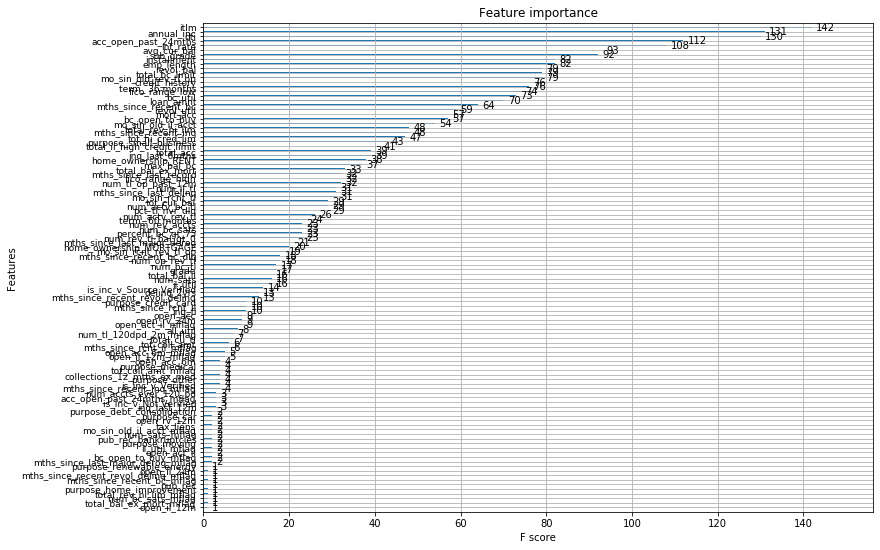

In [59]:
fig, ax = plt.subplots(figsize=(12, 9))
plot_importance(fitted_model_xgb.best_estimator_, ax=ax)
plt.yticks(size = 9)
plt.show()

/home/ubuntu/.venv/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


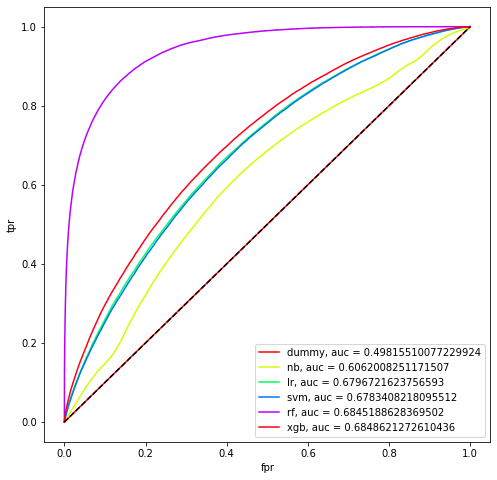

In [60]:
# plot roc curve of each fitted best models on training data with cv score as legend
color = iter(plt.cm.hsv(np.linspace(0,1,len(fitted_models.items()))))
plt.figure(figsize = (8,8))

for name, model in fitted_models.items():
    try:
        fpr, tpr, thresholds = roc_curve(y_train, model.best_estimator_.predict_proba(X_train)[:,1])
    except:
        fpr, tpr, thresholds = roc_curve(y_train, model.best_estimator_.decision_function(X_train))
    finally:
        plt.plot(fpr, tpr, c = next(color), label = "{}, auc = {}".format(name, model.best_score_))
        
plt.plot([0,1], [0,1], 'k--')
plt.legend()
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.show()    

In [61]:
end_file = timer()
print ('Time since training {}.'.format(timedelta(seconds = end_file - start_file)))

Time since training 3:38:00.909859.


**Notes:**
1. Xgb has the best validation score.
2. NB has the worst cv score, however, it is fast to train and an easy improvement from random guessing
3. Linear models have great performance given the fast training time. 
4. Random Forest is overfit, which could be further tuned to improve performance. 
5. Engineered features 'itlm' is one of the most import features, so is 'annual_income', which is the numerator for 'itlm' feature, thus highly correlated.
6. Pickled xgb model cannot be opened properly on local machine hence saved separatedly below.

In [2]:
with open('fitted_models.pkl','rb') as f:
    fitted_models = pickle.load(f)

In [3]:
# save xgb model separately
fitted_model_xgb = fitted_models['xgb']

In [5]:
del fitted_models['xgb']

In [12]:
abt_train = pd.read_csv('../data/abt/analytical_base_table-train.csv')
abt_train.shape

(442803, 167)

In [14]:
y_train = abt_train.loan_status
X_train = abt_train.drop('loan_status', axis = 1)

In [15]:
# checking models are saved accurately
for name, model in fitted_models.items():
    try:
        print (name, 'train_auc', roc_auc_score(y_train, model.best_estimator_.predict_proba(X_train)[:,1]))
    except:
        print (name, 'train_auc', roc_auc_score(y_train, model.best_estimator_.decision_function(X_train)))  

dummy train_auc 0.5001613635514557
nb train_auc 0.6123596828838467
lr train_auc 0.6858536258702257
svm train_auc 0.682509051820287
rf train_auc 0.9422135885022576


In [9]:
with open('fitted_models.pkl', 'wb') as f:
    pickle.dump(fitted_models, f)

In [10]:
with open('fitted_model_xgb.pkl', 'wb') as f:
    pickle.dump(fitted_model_xgb, f)

In [11]:
with open('fitted_models.pkl', 'rb') as f:
    saved_fitted_models = pickle.load(f)

In [16]:
for name, model in saved_fitted_models.items():
    try:
        print (name, 'train_auc', roc_auc_score(y_train, model.best_estimator_.predict_proba(X_train)[:,1]))
    except:
        print (name, 'train_auc', roc_auc_score(y_train, model.best_estimator_.decision_function(X_train)))  

dummy train_auc 0.5001613635514557
nb train_auc 0.6123596828838467
lr train_auc 0.6858536258702257
svm train_auc 0.682509051820287
rf train_auc 0.9422135885022576


In [3]:
abt_test = pd.read_csv('../data/abt/analytical_base_table-test.csv')

In [4]:
abt_test.shape

(102911, 167)

[back to top](#toc)

<a id = 'azeval'></a>
### 3. Analyze/Evaluation split
**- Split test data further into analysis (threshold selection) and evaluation**

In [5]:
abt_az = abt_test[:50000]
abt_az.shape

(50000, 167)

In [49]:
abt_az.shape

(50000, 167)

In [50]:
abt_az.to_csv('../data/abt/analytical_base_table-analyze.csv', index = False)

In [6]:
y_az = abt_az.loan_status
X_az = abt_az.drop('loan_status', axis = 1)
print (X_az.shape, y_az.shape)

(50000, 166) (50000,)


In [7]:
abt_eval = abt_test[50000:]
abt_eval.shape

(52911, 167)

In [8]:
y_eval = abt_eval.loan_status
X_eval = abt_eval.drop('loan_status', axis = 1)
print (X_eval.shape, y_eval.shape)

(52911, 166) (52911,)


[back to top](#toc)

<a id = 'thres'></a>

### 4. ROC Analysis & Threshold Selection
#### 4.A. Model Selection

In [9]:
def plot_roc_curves(fitted_models, X, y, name = 'ROC Analysis'):
    
    color = iter(plt.cm.hsv(np.linspace(0,1,len(fitted_models.items()))))
    plt.figure(figsize = (8,8))

    for name, model in fitted_models.items():
        try:
            fpr, tpr, thresholds = roc_curve(y, model.best_estimator_.predict_proba(X)[:,1])
            auc = roc_auc_score(y, model.best_estimator_.predict_proba(X)[:,1])
        except:
            fpr, tpr, thresholds = roc_curve(y, model.best_estimator_.decision_function(X))
            auc = roc_auc_score(y, model.best_estimator_.decision_function(X))
        finally:
            plt.plot(fpr, tpr, c = next(color), label = "{}, auc = {}".format(name, auc))

    plt.plot([0,1], [0,1], 'k--')
    plt.legend()
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.title(name)
    plt.show()    

In [11]:
with open('./fitted_models.pkl', 'rb') as f:
    fitted_models = pickle.load(f)

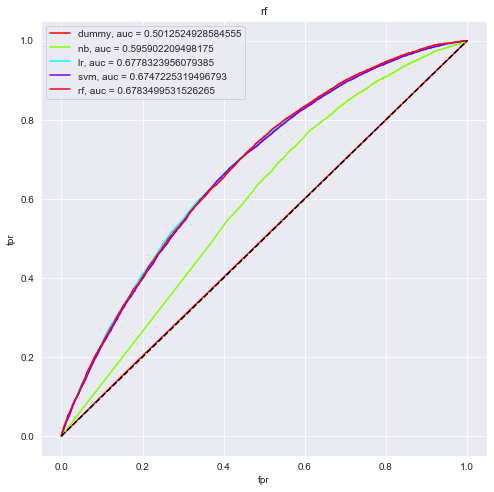

In [12]:
plot_roc_curves(fitted_models, X_az, y_az, 'ROC Analysis and Thresholds Picking')

**Notes:**
1. Serving as the baseline performance, **dummy classifier** falls perfectly on the diagonal line. 
2. **XGBoost**, despite having the best performance according to cross validation, cannot be opened properly on local machine, thus was eliminated from the analysis as other models that can be opened properly deliver similar performance. 
3. **Random Forest** delievers the second best performance during cross validation, top performance on analysis set, yet is more expensive to train and overfits and requires further tuning. 
4. **Logistic Regression**, as a simple model yiedling comparable results with rf and xgb, is selected as the final model for prediction.

In [13]:
fitted_model_lr = fitted_models['lr'].best_estimator_

In [51]:
roc_auc_score(y_az, fitted_model_lr.predict_proba(X_az)[:,1])

0.6778323956079385

[back to top](#toc)

<a id = 'thres-select'></a>
#### 4.B. Threshold Selection
#### 4.B.a. Metrics

In [63]:
fpr, tpr, thresholds = roc_curve(y_az, fitted_model_lr.predict_proba(X_az)[:,1])
thresholds_df = pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds})
thresholds_df.head()

,fpr,tpr,thresholds
0,0.000000,0.000000,2.000000
1,0.000000,0.000104,1.000000
2,0.000025,0.000104,0.999999
3,0.000025,0.000311,0.869917
4,0.000173,0.000311,0.644042


In [64]:
#dr = default rate
dr = abt_test.loan_status.mean()
print(dr)

0.2024564915315175


In [65]:
#edr = effective-default-rate
thresholds_df.loc[:, 'edr'] = dr*(1-thresholds_df.tpr)/(dr*(1-thresholds_df.tpr) + (1-dr)*(1-thresholds_df.fpr))

In [66]:
# percentage of loans left for Portfolio To total number of Loans
thresholds_df.loc[:, 'ptl'] = dr*(1-thresholds_df.tpr) + (1-dr)*(1-thresholds_df.fpr)

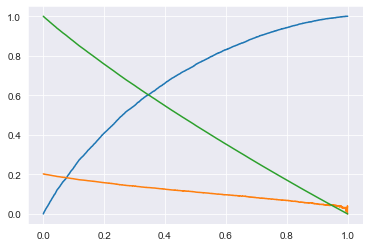

In [68]:
plt.plot(fpr, tpr)
plt.plot(fpr, thresholds_df.edr)
plt.plot(fpr, thresholds_df.ptl)
plt.show()

**Notes**:
1. `'edr'`provides a direct view of how our model would improve portfolio performance. We see the porfolio laon default rate improves from ~20% to 2% as we catch more defulat loans. It is worth noting, however, catching 80% of default loans will only reduce loan default rate from 20% to 10%, a reduction of 50%, due to non default loans being wrongly classified.
2. Looking at the green `'ptl'` line we can see that less than 40% of all loans are left in order to achieve a default rate of 10%. This might be a problem for some investors as they want more loans. However, as an individual investor who invests on smaller scale, 40% of all loans is around 30 loans availabel per week, which is more than enough.

[back to top](#toc)

<a id = 'thres-thres'></a>
#### 4.B.b. Thresholds

In [69]:
thresholds_df = thresholds_df.sort_values(['tpr', 'edr'], ascending=False)
thresholds_df.head()

,fpr,tpr,thresholds,edr,ptl
14691,0.999381,1.000000,0.011675,0.000000,0.000494
14692,1.000000,1.000000,0.001546,NaN,0.000000
14690,0.999381,0.999896,0.011815,0.040814,0.000515
14689,0.997845,0.999896,0.018219,0.012079,0.001740
14688,0.997845,0.999792,0.018277,0.023870,0.001761


In [70]:
thresholds_df.loc[thresholds_df.tpr >= 0.8, :].tail()

,fpr,tpr,thresholds,edr,ptl
11241,0.557584,0.800581,0.141097,0.102674,0.393219
11240,0.557584,0.800374,0.141113,0.102770,0.393262
11239,0.557535,0.800374,0.141118,0.102760,0.393301
11238,0.557535,0.800166,0.141121,0.102856,0.393343
11237,0.557485,0.800166,0.141124,0.102846,0.393383


In [72]:
thresholds_df = thresholds_df.sort_values(['fpr', 'edr'])
thresholds_df.head()

,fpr,tpr,thresholds,edr,ptl
1,0.000000,0.000104,1.000000,0.202440,0.999979
0,0.000000,0.000000,2.000000,0.202456,1.000000
3,0.000025,0.000311,0.869917,0.202410,0.999917
2,0.000025,0.000104,0.999999,0.202444,0.999959
5,0.000173,0.000415,0.631584,0.202417,0.999778


In [73]:
thresholds_df.loc[thresholds_df.fpr <= 0.6, :].tail()

,fpr,tpr,thresholds,edr,ptl
11740,0.599351,0.830582,0.132320,0.096937,0.353835
11743,0.599401,0.830790,0.132306,0.096841,0.353753
11742,0.599401,0.830686,0.132310,0.096894,0.353774
11745,0.599500,0.830894,0.132276,0.096809,0.353653
11744,0.599500,0.830790,0.132283,0.096862,0.353674


In [74]:
thresholds_df = thresholds_df.sort_values(['edr', 'fpr'])
thresholds_df.head()

,fpr,tpr,thresholds,edr,ptl
14691,0.999381,1.000000,0.011675,0.000000,0.000494
14687,0.995590,0.999792,0.022132,0.011811,0.003559
14689,0.997845,0.999896,0.018219,0.012079,0.001740
14685,0.995145,0.999689,0.022832,0.016021,0.003935
14686,0.995590,0.999689,0.022136,0.017613,0.003580


In [76]:
thresholds_df.loc[thresholds_df.edr <= 0.05, :].tail()

,fpr,tpr,thresholds,edr,ptl
14320,0.903386,0.980069,0.064086,0.049763,0.081089
14315,0.902519,0.979861,0.064360,0.049831,0.081822
14313,0.902073,0.979757,0.064446,0.049858,0.082199
14316,0.902792,0.979861,0.064306,0.049964,0.081605
14318,0.903362,0.979965,0.064102,0.049998,0.081130


In [77]:
# edr <= 0.05
thres_05 = np.asscalar(thresholds_df.loc[thresholds_df.edr <= 0.05, :].tail(1)['thresholds'].values)
thres_05

0.06410193764508962

In [78]:
thres_05_df = thresholds_df.loc[thresholds_df.edr <= 0.05, :].tail(1)

In [79]:
# edr <= 0.05
thresholds_df.loc[thresholds_df.edr <= 0.08, :].tail()

,fpr,tpr,thresholds,edr,ptl
12926,0.710927,0.901069,0.109664,0.079932,0.250577
12940,0.713677,0.902004,0.109176,0.079937,0.248195
12938,0.713082,0.901796,0.109287,0.079940,0.248711
12923,0.710704,0.900965,0.109696,0.079953,0.250776
12924,0.710754,0.900965,0.109684,0.079965,0.250737


In [81]:
thres_08_df = thresholds_df.loc[thresholds_df.edr <= 0.08, :].tail(1)
thres_08 = np.asscalar(thresholds_df.loc[thresholds_df.edr <= 0.08, :].tail(1)['thresholds'].values)
thres_08

0.10968430507396774

In [82]:
# edr <= 0.05
thresholds_df.loc[thresholds_df.edr <= 0.10, :].tail()

,fpr,tpr,thresholds,edr,ptl
11461,0.575074,0.814077,0.137352,0.099967,0.376539
11486,0.578889,0.815738,0.136611,0.099971,0.373160
11482,0.578195,0.815426,0.136727,0.099975,0.373776
11457,0.574454,0.813765,0.137472,0.099986,0.377096
11459,0.574702,0.813869,0.137418,0.099989,0.376877


In [83]:
thres_10_df = thresholds_df.loc[thresholds_df.edr <= 0.10, :].tail(1)
thres_10 = np.asscalar(thresholds_df.loc[thresholds_df.edr <= 0.10, :].tail(1)['thresholds'].values)
thres_10

0.13741758307667645

In [86]:
threshold_dict = {'thres_05': thres_05,
                'thres_05_df': thres_05_df,
                'thres_08': thres_08,
                'thres_08_df': thres_08_df,
                'thres_10': thres_10,
                'thres_10_df': thres_10_df}

In [87]:
with open('threshold_dict.pkl', 'wb') as f:
    pickle.dump(threshold_dict, f)

**NOTES:**

Using the logistic regression model, we have selected the following thresholds along with their corresponding effective default rate:
1. at threshold = 0.0641, analysis set has an effetive 5% default rate,
2. at threshold = 0.1097, analysis set has an effetive 8% default rate,
3. at threshold = 0.1374, analysis set has an effetive 10% default rate.

[back to top](#toc)

<a id = 'eval'></a>
### 5. Model Evaluation

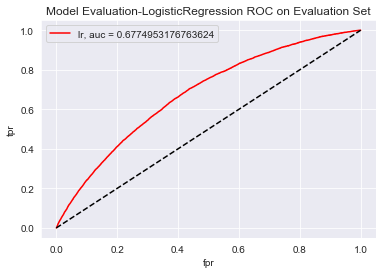

In [22]:
# evaluate on evaluation set
y_eval_score = fitted_model_lr.predict_proba(X_eval)[:,1]
fpr, tpr, thresholds = roc_curve(y_eval, y_eval_score)
auc = roc_auc_score(y_eval, y_eval_score)

plt.plot(fpr, tpr, 'r', label = "{}, auc = {}".format('lr', auc))

plt.plot([0,1], [0,1], 'k--')
plt.legend()
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Model Evaluation-LogisticRegression ROC on Evaluation Set')
plt.show()

In [23]:
thresholds_eval_df = pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds})
thresholds_eval_df.head()

,fpr,tpr,thresholds
0,0.000000,0.000000,2.000000
1,0.000024,0.000000,1.000000
2,0.000048,0.000000,0.999999
3,0.000048,0.000089,0.999999
4,0.000096,0.000089,0.999974


In [40]:
eval_dr = y_eval.mean()
eval_dr

0.21171401031921527

In [88]:
thresholds_eval_df.loc[:, 'edr'] = (eval_dr*(1-thresholds_eval_df.tpr)/
                                    (eval_dr*(1-thresholds_eval_df.tpr)+(1-eval_dr)*(1-thresholds_eval_df.fpr)))  

In [93]:
thresholds_eval_df[thresholds_eval_df.thresholds > thres_05].tail()

,fpr,tpr,thresholds,edr
15917,0.884222,0.971791,0.064384,0.061419
15918,0.885109,0.971791,0.064136,0.061864
15919,0.885109,0.971880,0.064120,0.061680
15920,0.885157,0.971880,0.064115,0.061704
15921,0.885157,0.971969,0.064114,0.061520


In [94]:
thresholds_eval_df[thresholds_eval_df.thresholds > thres_08].tail()

,fpr,tpr,thresholds,edr
14097,0.681699,0.879843,0.109739,0.092053
14098,0.681723,0.879843,0.109734,0.092059
14099,0.681723,0.880021,0.109712,0.091935
14100,0.681795,0.880021,0.109699,0.091954
14101,0.681795,0.880111,0.109688,0.091892


In [95]:
thresholds_eval_df[thresholds_eval_df.thresholds > thres_10].tail()

,fpr,tpr,thresholds,edr
12413,0.549977,0.791644,0.137542,0.110595
12414,0.550097,0.791644,0.137513,0.110621
12415,0.550097,0.791734,0.137493,0.110579
12416,0.550529,0.791734,0.137428,0.110674
12417,0.550529,0.791823,0.137428,0.110631


**NOTES:**
Using the logistic regression model and threshold chosen, portfolio performance on the evaluation set is:
1. for 5% effective default rate threshold, evaluation set performance is 6% default rate,
2. for 8% effective default rate threshold, evaluation set performance is 9% default rate,
3. for 10% effective default rate threshold, evaluation set performance is 11% default rate.

[back to top](#toc)

<a id = 'notes'></a>

### 4. Notes:
1. **Train/test split**: 
Train data are all loans issued prior to 2016 august.


2. **Model Training and Selection**:
    1. Xgb has the best validation score.
    2. NB has the worst cv score, however, it is fast to train and an easy improvement from random guessing
    3. Linear models have great performance given the fast training time. 
    4. Random Forest is overfit, which could be further tune to improve performance. 
    5. Engineered features 'itlm' is one of the most import features, so is 'annual_income', which is the numerator for 'itlm' feature, thus highly correlated.
    6. Pickled xgb model cannot be opened properly on local machine hence saved separatedly below.


3. **ROC analysis, model and threshold selection**: 
    1. Model Selection:
        1. Serving as the baseline performance, **dummy classifier** falls perfectly on the diagonal line. 
        2. **XGBoost**, despite having the best performance according to cross validation, cannot be opened properly on local machine, thus was eliminated from the analysis as other models that can be opened properly deliver similar performance. 
        3. **Random Forest** delievers the second best performance during cross validation, top performance on analysis set, yet is more expensive to train and overfits and requires further tuning. 
        4. **Logistic Regression**, as a simple model yiedling comparable results with rf and xgb, is selected as the final model for prediction.
    2. Threshold Selection:
        1. Metrics:
            1. `'edr'`provides a direct view of how our model would improve portfolio performance. We see the porfolio laon default rate improves from ~20% to 2% as we catch more defulat loans. It is worth noting, however, catching 80% of default loans will only reduce loan default rate from 20% to 10%, a reduction of 50%, due to non default loans being wrongly classified.
            2. Looking at the green `'ptl'` line we can see that less than 40% of all loans are left in order to achieve a default rate of 10%. This might be a problem for some investors as they want more loans. However, as an individual investor who invests on smaller scale, 40% of all loans is around 30 loans availabel per week, which is more than enough.     
        2. Thresholds: Using the logistic regression model, we have selected the following thresholds along with their corresponding effective default rate:
            1. at threshold = 0.0641, analysis set has an effetive 5% default rate,
            2. at threshold = 0.1097, analysis set has an effetive 8% default rate,
            3. at threshold = 0.1374, analysis set has an effetive 10% default rate.
    

4. **Model Evaluation**:
Using the logistic regression model and threshold chosen, portfolio performance on the evaluation set is:
    1. for 5% effective default rate threshold, evaluation set performance is 6% default rate,
    2. for 8% effective default rate threshold, evaluation set performance is 9% default rate,
    3. for 10% effective default rate threshold, evaluation set performance is 11% default rate.


**End of current notebook**

**[back to top](#toc)**

---

**Previous notebook: [part 2 - dataCleaning + featureEngineering](proj-classification-loanDefault-p2-dataCleaning-featureEngineering-max-v20200225-remote.ipynb)**

**Next notebook: [part 4 - projectDelievery](proj-classification-loanDefault-p4-projectDelievery-max-v2020Mar.ipynb)**